In [397]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torch 
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# 1.2 Experiment (20 Points)

In [398]:
def k_means(data, k, max_iter = 100, n_restarts = 100):
    objective_min = np.inf
    centroid_best = None
    labels_best = None
    for restart in range(n_restarts):
        centroids = data[np.random.choice(data.shape[0], k, replace = False), :]
        for i in range(max_iter):
            #data.shape = (n_sample, n_features) = (1500, 2)
            #centroids.shape = (n_clusters, n_features) = (5, 2)
            # (n_clusters, n_samples, n_features) = (5, 1, 2)
            # data - centroids[:, np.newaxis] = (n_clusters, n_samples, n_features)
            # sum(axis = 2) result resulting in an array of shape (n_clusters, n_samples) containing the squared 
            #    Euclidean distances between each data point and each centroid.
            labels = np.argmin(((data - centroids[:, np.newaxis])**2).sum(axis = 2), axis = 0)
            # returns the indices of the minimum values along columns.
            for j in range(k):
                # choose columns with a row value of true
                # in this case, there're 5 centroids
                centroids[j] = data[labels == j, :].mean(axis = 0)
        # picking the one with the lowest objective value
        objective = np.sum(((data - centroids[labels, :])**2).sum(axis = 1))
        if objective_min > objective:
            objective_min = objective
            centroid_best = centroids
            labels_best = labels

    return centroid_best, labels_best

In [399]:
# Use k-means++ initialization strategy
# k-means++ algorithm selects the initial centroids to be well-spaced and tries to improve the convergence of the k-means algorithm.

def kmean_plus(data, k, max_iter = 200, n_restarts = 500):
    """
    kmeans.labels_ : returns an array of cluster labels, where each element corresponds 
        to a data point and specifies which cluster it belongs to.
    centroids[labels] uses these labels to index the centroids array, so that 
        each data point is paired with its assigned centroid.
    """
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    objective_min = np.inf
    centroid_best = None

    for restart in range(n_restarts):
        kmeans = KMeans(n_clusters= k, init = 'k-means++', max_iter = max_iter).fit(data)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        # calculates the sum of squared distances between each data point and its assigned centroid.
        objective = np.sum((data - centroids[labels]) ** 2)

        if objective_min > objective:
            objective_min = objective
            centroid_best = centroids
            labels_best = labels
        
    return objective_min, centroid_best, labels_best

#### Expectation maximization algorith for GMMs:

In [400]:
# responsibility matrix for each sample and cluster
def compute_respon(data, k, means, covariances, weights):
    n_data, n_features = data.shape
    respon = np.zeros((n_data, k))
    for j in range(k):
        # calculates the probability density function (PDF) of a multivariate normal distribution 
        # at a given set of points.
        # used in the E-step to compute the responsibilities of each data point for each mixture component.
        # calculating the posterior probability of each data point being in the j-th cluster. 
        respon[:, j] = weights[j] * multivariate_normal.pdf(data, mean = means[j], cov = covariances[j])
    # respon has shape (n_data, k), normal has shape (n_data, 1)
    # Therefore, we need to add extra axis so that it has the same shape as respon
    normal = np.sum(respon, axis = 1)[:, np.newaxis]
    #normalize the responsibility across each cluster
    return respon/normal

In [401]:
#has error
def gmm(data, k, max_iter = 100, n_restarts = 10):
    np.random.seed(0)
    obj_min = np.inf
    best_means = None
    best_covs = None
    best_weights = None
    best_labels = None
    n_data, n_features = data.shape

    for ind in range(n_restarts):
        # Initialize parameters
        # the weights are initialized uniformly.
        # the means are randomly chosen from the input data.
        # the covariance matrices are initialized as the identity matrix.
        weights = np.ones(k) / k
        means = data[np.random.choice(n_data, k, replace = False), :]
        cov = np.array([np.eye(n_features) + 1e-6*np.diag(np.ones(n_features)) for i in range (k)])
        # E-step: compute responsibilities
        for i in range(max_iter):
            likelihoods = np.zeros((n_data,k))
            likelihoods = np.array([multivariate_normal.logpdf(data, means[j], cov[j], allow_singular= False) for j in range(k)]).T 
            # weights = (k,)
            # (n_data, k): The probability of each data belong to one cluster
            joint_prob = likelihoods * weights
            respon = joint_prob / joint_prob.sum(axis = 1)[:, np.newaxis]
            #respon = compute_respon(data, k, means, cov, weights)
            # Nk[i] represents the sum of responsibilities for cluster 'i' over all data points. 
            # This value is used in the M-step of the EM algorithm to update the 
            # cluster weights, means, and covariances.
            Nk = np.sum(respon, axis = 0)
            # ensures that the weights sum up to 1, 
            # which is a requirement for probabilities.
            # Updates the prior probabilities of the data points
            # belonging to each of the Gaussian mixture components.
            weights = Nk/n_data
            # updated based on the current responsibilities and the data.
            # data = (1500, 2) = (n_data, n_features)
            # respon = (1500, 5) = (n_data, k)'
            # Weighted sum of the data points, where the weights are given by
            # the responsibilities of the Gaussian components for each data point.
            # Nk[:, np.newaxis] has shape (k, 1)
            # divide each row of the weighted sum by the corresponding value of Nk
            means = (respon.T @ data) / Nk[: , np.newaxis]
            # means = (k,n_features)
            for j in range(k):
                # (num_data, num_features)
                diff = data - means[j]
                cov[j] = (respon[:, j, np.newaxis]).T @ diff / Nk[j]
        objective = -np.log(likelihoods.sum(axis = 1)).sum()
        labels = np.argmax(respon, axis = 1)
        if objective < obj_min:
            obj_min = objective
            best_labels = labels
            best_covs = cov
            best_means = means
            best_weights = weights
    return best_means, best_covs, best_weights, best_labels, obj_min

In [402]:
# has error
def gmm_v2_1(data, k, max_iter=100, n_restarts= 10):
    data = torch.from_numpy(data).float()
    best_labels, best_means, best_covs, best_mixing_coeffs = None, None, None, None
    best_objective = -np.inf
    n_data, n_features = data.shape

    for _ in range(n_restarts):
        means = torch.randn(k, n_features)
        covs = torch.stack([torch.eye(n_features) for _ in range(k)]) #shape [3,2,2]
        mixing_coeffs = torch.ones(k)/k

        for _ in range(max_iter):
            normal_dis = torch.distributions.MultivariateNormal(means, covs)
            likelihoods = normal_dis.log_prob(data.unsqueeze(1))
            likelihoods = likelihoods.transpose(0,1)
            respon = mixing_coeffs.unsqueeze(1) * torch.exp(likelihoods)
            respon = respon/ respon.sum(dim = 1, keepdim = True)
            # respon.shape = [3, 300]
            #M-step
            Nk = respon.sum(dim = 1) #shape [3]
            means = torch.matmul(respon, data)
            means = means/ Nk[:, None] #shape [3, 2]
            # data.shape = [300, None, 2] - [None, 3,2]
            diff = data[:, None, :] - means[None, :, :] #shape (300, 3, 2)
            covs = torch.einsum('nik,njk->kij', diff, diff * respon.transpose(0, 1).unsqueeze(-1))
            covs = covs/ Nk[:, None, None]
            mixing_coeffs = Nk/n_data

            #Compute Log-likelihood
            llh = torch.sum(torch.log(torch.sum(mixing_coeffs * torch.exp(likelihoods.T), dim = 1)))

            if llh - best_objective < 1e-6:
                break
            best_objective = llh
        
        if best_objective > -np.inf:
            labels = torch.argmax(respon, dim = 1)
            if best_labels is None or np.sum(labels == best_labels) < np.sum(best_labels == best_labels):
                best_labels = labels
                best_means = means
                best_covs = covs
                best_mixing_coeffs = mixing_coeffs
    return best_labels.numpy(), best_means.numpy(), best_covs.numpy(), best_mixing_coeffs.numpy(), best_objective.numpy()

In [403]:
def gmm_v2(data, k, max_iter=200, n_restarts= 500, linkage = 'ward', metric = 'euclidean', eps =0.5, min_samples = 5):
    best_gmm = None 
    best_objective = -np.inf
    n_data, n_features = data.shape
    for _ in range(n_restarts):
        #Use AgglomerativeClustering to get initial cluster means
        clustering = AgglomerativeClustering(n_clusters= k, linkage= linkage, affinity= metric).fit(data)
        init_means = np.zeros((k, n_features))
        for i in range(k):
            init_means[i] = np.mean(data[clustering.labels_ == i], axis = 0)
        #Use initial means to initalize GMM parameters
        gmm = GaussianMixture(n_components= k, means_init= init_means, max_iter = max_iter, n_init = 1)
        gmm.fit(data)
        if gmm.lower_bound_ > best_objective:
            best_gmm = gmm
            best_objective = gmm.lower_bound_
    return best_gmm.means_, best_gmm.covariances_, best_gmm.weights_, best_gmm.predict(data), best_objective

In [404]:
np.ones(5).shape

(5,)

In [405]:
np.array([np.eye(2) for i in range (5)])

array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]])

## Clustering accuracy

In [406]:
import itertools

In [407]:
def kmean_cluster_accuracy(centroids, labels, true_labels):
    """
    labels: an array containing index of  cluster produced by one of the above 
    true_labels: array containing the true cluster assignments 
    """
    true_means = np.array([[-1, -1], [1, -1], [0, 1]])
    mapping = []
    for i in range(3):
        idx = (labels == i)
        idx = np.nonzero(idx)[0] # get the index 
        # if a cluster is empty, it is assigned a mapping of -1 
        if np.sum(idx) == 0:
            mapping.append(-1)
            # to skip the current iteration of the loop and move on to the next iteration.
            continue
        distances = np.linalg.norm(centroids[i] - true_means, axis = 1)
        closest_means = np.argmin(distances) #location of the closest true mean
        mapping.append(closest_means)
    predicted_labels = np.array([mapping[label] for label in labels])
    accuracy = (predicted_labels == true_labels).mean()
    return accuracy

In [408]:
def gmm_cluster_accuracy(means, labels, true_labels):
    true_means = np.array([[-1, -1], [1, -1], [0, 1]])
    # Compute the distance between cluster means and true means
    dist = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            dist[i,j] = np.linalg.norm(means[i] - true_means[j])
    
    perm = np.array(list(itertools.permutations([0,1,2])))
    best_perm =perm[np.argmin(np.sum(dist[perm], axis = 1))]

    mapped_labels = np.zeros_like(labels)
    for i in range(3):
        mapped_labels[labels == i] = best_perm[i]
    
    accuracy = np.mean(mapped_labels == true_labels)
    return accuracy

In [409]:
perm = np.array(list(itertools.permutations([0,1,2])))
perm

array([[0, 1, 2],
       [0, 2, 1],
       [1, 0, 2],
       [1, 2, 0],
       [2, 0, 1],
       [2, 1, 0]])

In [410]:
sigmas = [0.5, 1, 2, 4, 8]
mu1 = np.array([-1, -1])
mu2 = np.array([1, -1])
mu3 = np.array([0, 1])
sigma1 = np.array([[2, 0.5], [0.5, 1]])
sigma2 = np.array([[1, -0.5], [-0.5, 2]])
sigma3 = np.array([[1, 0], [0, 2]])
np.random.seed(0)
numpoints = 100
data = np.empty((0, 2), float)
accuracy_kmean_list = []
for sigma in sigmas:
    multi = np.random.multivariate_normal(mu1, sigma*sigma1, numpoints)
    multi2 = np.random.multivariate_normal(mu2, sigma*sigma2, numpoints)
    multi3 = np.random.multivariate_normal(mu3, sigma*sigma3, numpoints)
    dataset = np.concatenate((multi, multi2, multi3))
    data = np.concatenate((data, dataset)) 
    true_label = np.repeat(np.arange(3), numpoints)

    objective_plus,centroid_best_plus, labels_best_plus = kmean_plus(dataset, 3)
    accuracy = kmean_cluster_accuracy(centroid_best_plus, labels_best_plus, true_label)
    accuracy_kmean_list.append([accuracy, objective_plus, sigma])

In [421]:
accuracy_gmm_list = []
for sigma in sigmas:
    multi = np.random.multivariate_normal(mu1, sigma*sigma1, numpoints)
    multi2 = np.random.multivariate_normal(mu2, sigma*sigma2, numpoints)
    multi3 = np.random.multivariate_normal(mu3, sigma*sigma3, numpoints)
    dataset = np.concatenate((multi, multi2, multi3))
    data = np.concatenate((data, dataset)) 
    true_label = np.repeat(np.arange(3), numpoints)
    means, _, _, labels_best_gmm, objective_gmm = gmm_v2(dataset, 3)
    accuracy_gmm = gmm_cluster_accuracy(means, labels_best_gmm, true_label)
    accuracy_gmm_list.append([accuracy_gmm, -objective_gmm, sigma])

In [422]:
accuracy_gmm_list = pd.DataFrame(accuracy_gmm_list, columns = ['accuracy', 'objective', 'sigma'])
accuracy_gmm_list

,accuracy,objective,sigma
0,0.836667,3.111398,0.5
1,0.333333,3.451733,1.0
2,0.193333,4.090433,2.0
3,0.256667,4.686926,4.0
4,0.386667,5.275395,8.0


In [413]:
accuracy_kmean_list = pd.DataFrame(accuracy_kmean_list, columns= ['accuracy', 'objective', 'sigma'])
accuracy_kmean_list

,accuracy,objective,sigma
0,0.793333,214.332572,0.5
1,0.710000,214.422178,1.0
2,0.613333,249.910734,2.0
3,0.573333,262.848510,4.0
4,0.476667,267.524405,8.0


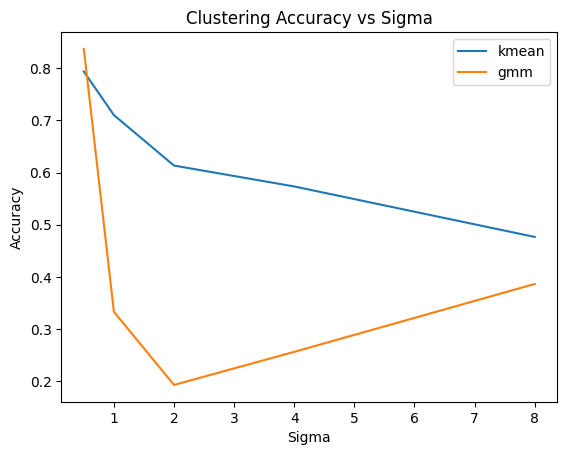

In [423]:
plt.plot(accuracy_kmean_list['sigma'], accuracy_kmean_list['accuracy'], label = 'kmean')
plt.plot(accuracy_gmm_list['sigma'], accuracy_gmm_list['accuracy'], label = 'gmm')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('Clustering Accuracy vs Sigma')
plt.legend()
plt.show()

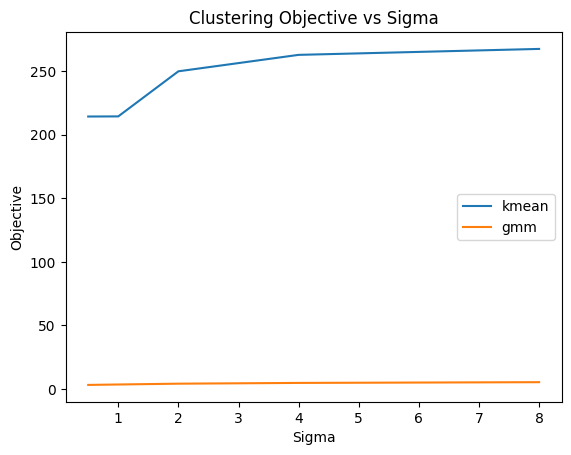

In [424]:
plt.plot(accuracy_kmean_list['sigma'], accuracy_kmean_list['objective'], label = 'kmean')
plt.plot(accuracy_gmm_list['sigma'], accuracy_gmm_list['objective'], label = 'gmm')
plt.xlabel('Sigma')
plt.ylabel('Objective')
plt.title('Clustering Objective vs Sigma')
plt.legend()
plt.show()